# <h1 align="center"><font color="red">Previsão de série temporal com Prophet em Python</font></h1>

<font color="yellow">Data Scientist.: Dr. Eddy Giusepe Chirinos Isidro</font>

# <font color="gree">Contextualizando</font>

<font color="orange">A previsão de série temporal pode ser desafiadora, pois há muitos métodos diferentes que você pode usar e muitos hiperparâmetros diferentes para cada método.

A `biblioteca prophet` é uma biblioteca de código aberto projetada para fazer previsões (`forecasts`) para conjuntos de dados de `séries temporais univariadas`. É fácil de usar e projetado para encontrar automaticamente um bom conjunto de hiperparâmetros para o modelo, em um esforço para fazer previsões hábeis para dados com tendências e estrutura sazonal por padrão.</font>



Instalação:
```
$ pip install prophet
```

In [1]:
# verifique a versão de prophet:
import prophet
# Versão:
print('Prophet %s' % prophet.__version__)

Prophet 1.1.5


# <font color="gree">Dataset</font>

<font color="orange">Usaremos o conjunto de dados mensais de vendas de carros.

É um conjunto de dados de `série temporal univariado` padrão que contém uma `tendência` e uma `sazonalidade`. O conjunto de dados tem 108 meses de dados e uma previsão de persistência ingénua (naive) pode atingir um `erro médio absoluto` de cerca de `3.235` vendas, proporcionando um limite de erro mais baixo.</font>

# <font color="gree">Carregar e resumir conjunto de dados</font>

<font color="orange">Primeiro, vamos carregar e resumir o conjunto de dados.

O `prophet` exige que os dados estejam em `DataFrames do Pandas`. Portanto, carregaremos e resumiremos os dados usando Pandas.

Podemos carregar os dados diretamente do `URL` chamando a função `read_csv()` Pandas e, em seguida, resumir a forma (número de linhas e colunas) dos dados e visualizar as primeiras linhas de dados.</font>

In [2]:
from pandas import read_csv
# Carregar os Dados de vendas de Carros:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'

df = read_csv(path, header=0)
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [3]:
df.shape

(108, 2)

# <font color="gree">Carregar e plotar conjunto de dados</font>

<font color="orange">Um conjunto de dados de série temporal não faz sentido para nós até que o representemos. Traçar uma série temporal nos ajuda a realmente ver se há uma `tendência`, `um ciclo sazonal`, `valores discrepantes` e muito mais. Isso nos dá uma ideia dos dados.

Podemos plotar os dados facilmente no `Pandas` chamando a função `plot()` no DataFrame.</font>

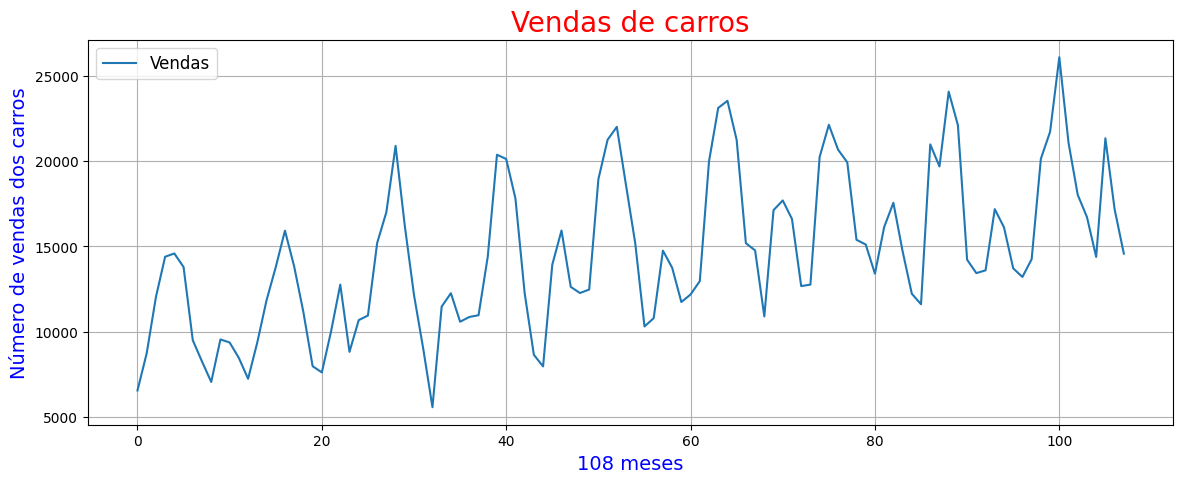

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.figure(figsize=(30, 8))
df.plot()
plt.grid(True)
plt.gcf().set_size_inches(14, 5)
plt.title('Vendas de carros', fontsize=20, c="r")
plt.xlabel('108 meses', fontsize=14, c="b")
plt.ylabel('Número de vendas dos carros', fontsize=14, c="b")
# Adicionar uma legenda personalizada e desconsiderar a padrão:
plt.legend(['Vendas'], fontsize=12)
plt.show()

`Insight`

<font color="gree">Podemos ver claramente a tendência nas vendas ao longo do tempo e um `padrão sazonal mensal nas vendas`. Esses são padrões que esperamos que o modelo de previsão leve em consideração.</font>

# <font color="pink">Previsão (`Forecast`) de vendas de carros com o `prophet`</font>

<font color="orange">Nesta seção, exploraremos o uso de `prophet` para prever o conjunto de dados de vendas de carros. Vamos começar ajustando um modelo ao conjunto de dados</font>

## <font color="red">Fit de um Modelo com prophet</font>

<font color="orange">Para usar o `prophet` para `forecasting` (previsão), primeiro, um objeto `Prophet()` é definido e configurado e, em seguida, ele é ajustado ao conjunto de dados chamando a função `fit()` e passando os dados.

O objeto `Prophet()` recebe argumentos para configurar o tipo de modelo desejado, como o tipo de crescimento, o tipo de sazonalidade e muito mais. `Por padrão, o modelo trabalhará duro para descobrir quase tudo automaticamente.`

A função `fit()` usa um DataFrame de dados de série temporal. O `DataFrame` deve ter um formato específico. `A primeira coluna deve ter o nome 'ds' e conter as datas e horas.` `A segunda coluna deve ter o nome ‘y’ e conter as observações.`

Isso significa que alteramos os nomes das colunas no conjunto de dados. Também requer que a primeira coluna seja convertida em objetos de data e hora, se ainda não o foram (por exemplo, isso pode ser desativado como parte do carregamento do conjunto de dados com os argumentos corretos para read_csv ).

Por exemplo, podemos modificar nosso conjunto de dados de vendas de carros carregados para ter esta estrutura esperada, como segue:</font>

In [37]:
from pandas import read_csv
from pandas import to_datetime
from prophet import Prophet # https://facebook.github.io/prophet/docs/quick_start.html#python-api

# Carregar os Dados:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0)

# Preparar os nomes das colunas esperadas:
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])
df.head()


,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026
3,1960-04-01,14395
4,1960-05-01,14587


In [38]:
# Defina o modelo:
model = Prophet()

# Ajuste o modelo:
model.fit(df)

02:29:45 - cmdstanpy - INFO - Chain [1] start processing


02:29:45 - cmdstanpy - INFO - Chain [1] done processing


## <font color="red">Faça uma previsão (`forecast`) dentro da amostra</font>

Pode ser útil fazer um `forecast` com base em dados históricos. Ou seja, podemos fazer um `forecast` sobre os dados utilizados como entrada para treinar o modelo. Idealmente, o modelo já viu os dados antes e faria uma previsão perfeita.

No entanto, este não é o caso, uma vez que o modelo tenta generalizar para todos os casos nos dados. Isso é chamado de fazer um `forecast` dentro da amostra (`na amostra do conjunto de treinamento`) e a revisão dos resultados pode fornecer informações sobre a qualidade do modelo. Ou seja, quão bem aprendeu os dados de treinamento.

Um `forecast` é feita chamando a função `predict()` e passando um DataFrame que contém uma `coluna chamada 'ds'` e linhas com datas e horas para todos os intervalos a serem previstos.

Existem muitas maneiras de criar esse DataFrame de “previsão” (forecast). Neste caso, faremos um loop em um ano de datas, por exemplo, os últimos 12 meses no conjunto de dados, e criaremos uma string para cada mês. Em seguida, converteremos a lista de datas em um DataFrame e converteremos os valores da string em objetos de data e hora.

In [43]:
import warnings
# Suprimir todos os avisos:
warnings.filterwarnings('ignore')

          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14357.589231  12849.699589  15894.499109
1 1968-02-01  14924.193677  13400.075505  16558.038237
2 1968-03-01  20874.583843  19319.391172  22442.702625
3 1968-04-01  22898.766190  21316.169054  24469.415600
4 1968-05-01  24196.259875  22731.321959  25910.482933


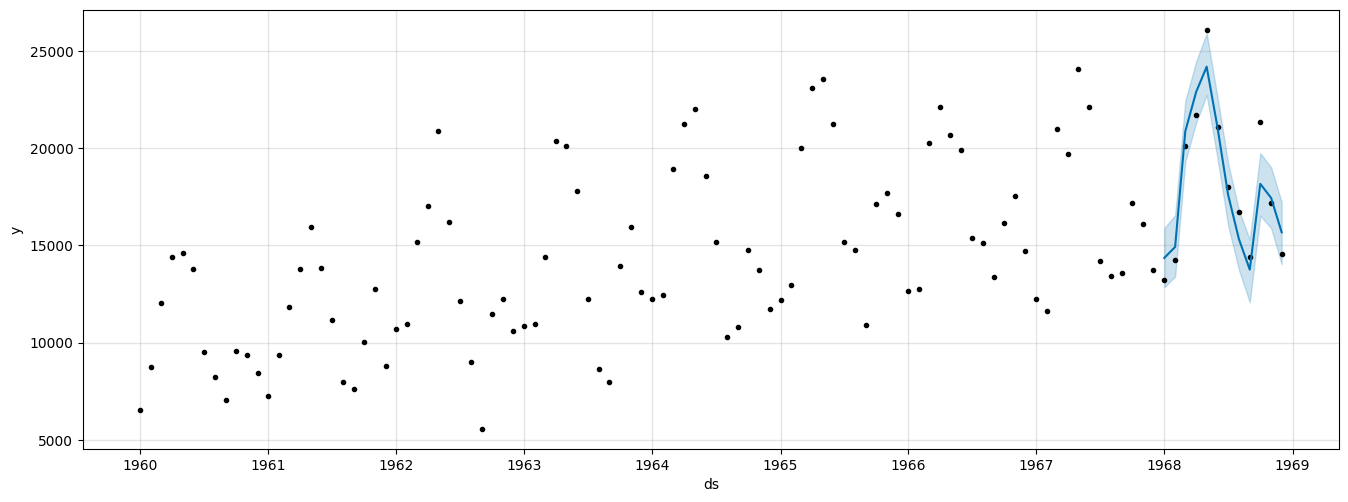

In [48]:
from pandas import to_datetime
from pandas import DataFrame
# from fbprophet import Prophet
from matplotlib import pyplot

# Definimos o período para o qual queremos uma previsão:
future = list()
for i in range(1, 13):
 date = '1968-%02d' % i
 future.append([date])

future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

# Usamos o modelo para fazer uma previsão:
forecast = model.predict(future)

# Resume sa previsão:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plot forecast:
model.plot(forecast)
plt.grid(True)
plt.gcf().set_size_inches(14, 5)
plt.show()